In [1]:
import sys
sys.path.append('src')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path
import typing

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align, prealign, viz  # type: ignore

# Align a Podcast

We would like to be able to align real-world data. That means longer tracks, along with real transcriptions. We'll be working with a podcast here. First, the config:

In [6]:
fixtures_path = Path("fixtures")
metadata = fixtures_path / "keanu.csv"
cfg = utils.load_config("english")
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
device = "cpu"

The aligner:

In [7]:
aligner = align.Aligner.build(device, cfg)
loader = DataLoader(
    ds,
    batch_size=1,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

/Users/ranykeddo/anaconda3/envs/timething/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Cleaner:

In [8]:
clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab)

The data:

In [9]:
batch = next(iter(loader))
xs, ys, ys_original, ids = batch

We have around 30 minutes of audio:

In [10]:
n_seconds = len(xs.squeeze()) / cfg.sampling_rate
n_minutes = n_seconds / 60
f"{n_minutes:.2f} minutes of audio"

'26.22 minutes of audio'

In [11]:
def audio_window(xs, offset_seconds, length_seconds, cfg):
    "A smaller window of audio snipped out of x"
    offset = cfg.sampling_rate * offset_seconds
    duration = cfg.sampling_rate * length_seconds
    return xs[:, :, offset:(offset+duration)]

offset_seconds = 10
length_seconds = 10
snippet = audio_window(xs, offset_seconds, length_seconds, cfg)

Let's have a listen:

In [12]:
ipd.Audio(snippet.squeeze(), rate=cfg.sampling_rate)

In [13]:
logprobs = aligner.logp(snippet)
logprobs

tensor([[[-2.8113e+00, -2.5195e+01, -2.5055e+01,  ..., -9.6140e+00,
          -9.6212e+00, -1.3315e+01],
         [-1.4825e-02, -2.6637e+01, -2.6504e+01,  ..., -1.5009e+01,
          -1.3617e+01, -1.5832e+01],
         [-1.6380e+00, -2.3542e+01, -2.3344e+01,  ..., -1.3851e+01,
          -1.2330e+01, -1.3151e+01],
         ...,
         [-8.1797e-01, -2.2445e+01, -2.2454e+01,  ..., -1.4015e+01,
          -7.0001e+00, -1.5221e+01],
         [-1.2933e+01, -2.2934e+01, -2.2958e+01,  ..., -1.7339e+01,
          -1.4247e+01, -1.8423e+01],
         [-5.0309e-03, -2.5165e+01, -2.5148e+01,  ..., -1.5883e+01,
          -1.2062e+01, -1.6954e+01]]])

Let's argmax decode this snippet:

In [14]:
prediction = prealign.decode_best(logprobs, aligner.vocab).lower()
transcript = ys[0].lower()
prediction

'sible iconbut i have a question for you is it possible to even get near the bottom of ceonterweavesi think he might '

In [15]:
# Let's check out the query windows we are using for this search:
n_chars = 80
query_windows = prealign.windows(prediction, n_chars=n_chars)

# show all query windows
query_windows

['sible iconbut i have a question for you is it possible to even get near the bott',
 'is it possible to even get near the bottom of ceonterweavesi think he might ']

In [16]:
transcript_windows = prealign.windows(transcript, n_chars=n_chars)

# show a few transcript windows
transcript_windows[:10]

['no matter the role, the actor is reflecting your desires of what you want him to',
 'ing your desires of what you want him to be. alex pappademas, you’ve written a b',
 ' be. alex pappademas, you’ve written a book. yeah, how about that? it’s called “',
 'ook. yeah, how about that? it’s called “keanu reeves: most triumphant: the movie',
 'keanu reeves: most triumphant: the movies and meaning of an irrepressible icon.”',
 's and meaning of an irrepressible icon.” but i have a question for you. is it po',
 ' but i have a question for you. is it possible to even get near the bottom of ke',
 'ssible to even get near the bottom of keanu reeves? i think he might be an unkno',
 'anu reeves? i think he might be an unknowable icon. i sit before you as someone ',
 'wable icon. i sit before you as someone who’s thought about him for a whole year']

Let's search:

In [17]:
n_chars = 80
print(prediction)
matches = list(prealign.similarity(prediction, transcript, n_chars=n_chars, threshold=0.3))
for m in matches:
    q, t, prob = m
    print(f"\n----MATCH (probability {prob})\n\nQUERY WINDOW \n'{query_windows[q]}'\n\nTRANSCRIPT WINDOW \n'{transcript_windows[t]}'\n")

sible iconbut i have a question for you is it possible to even get near the bottom of ceonterweavesi think he might 

----MATCH (probability 0.30578512396694213)

QUERY WINDOW 
'sible iconbut i have a question for you is it possible to even get near the bott'

TRANSCRIPT WINDOW 
's and meaning of an irrepressible icon.” but i have a question for you. is it po'


----MATCH (probability 0.6458333333333334)

QUERY WINDOW 
'sible iconbut i have a question for you is it possible to even get near the bott'

TRANSCRIPT WINDOW 
' but i have a question for you. is it possible to even get near the bottom of ke'


----MATCH (probability 0.3684210526315789)

QUERY WINDOW 
'is it possible to even get near the bottom of ceonterweavesi think he might '

TRANSCRIPT WINDOW 
' but i have a question for you. is it possible to even get near the bottom of ke'


----MATCH (probability 0.43119266055045874)

QUERY WINDOW 
'is it possible to even get near the bottom of ceonterweavesi think he might '

TRANSCRI

In [20]:
print(f"matching {len(query_windows)} query windows against {len(transcript_windows)} transcript windows")
full_matches = list(prealign.similarity(prediction, transcript, n_chars=n_chars, threshold=0.08))
full_matches

matching 2 query windows against 512 transcript windows


[(0, 5, 0.30578512396694213),
 (0, 6, 0.6458333333333334),
 (0, 7, 0.2153846153846154),
 (0, 152, 0.14492753623188406),
 (0, 153, 0.14492753623188406),
 (1, 6, 0.3684210526315789),
 (1, 7, 0.43119266055045874),
 (1, 8, 0.09859154929577464)]

ValueError: not enough values to unpack (expected 2, got 0)

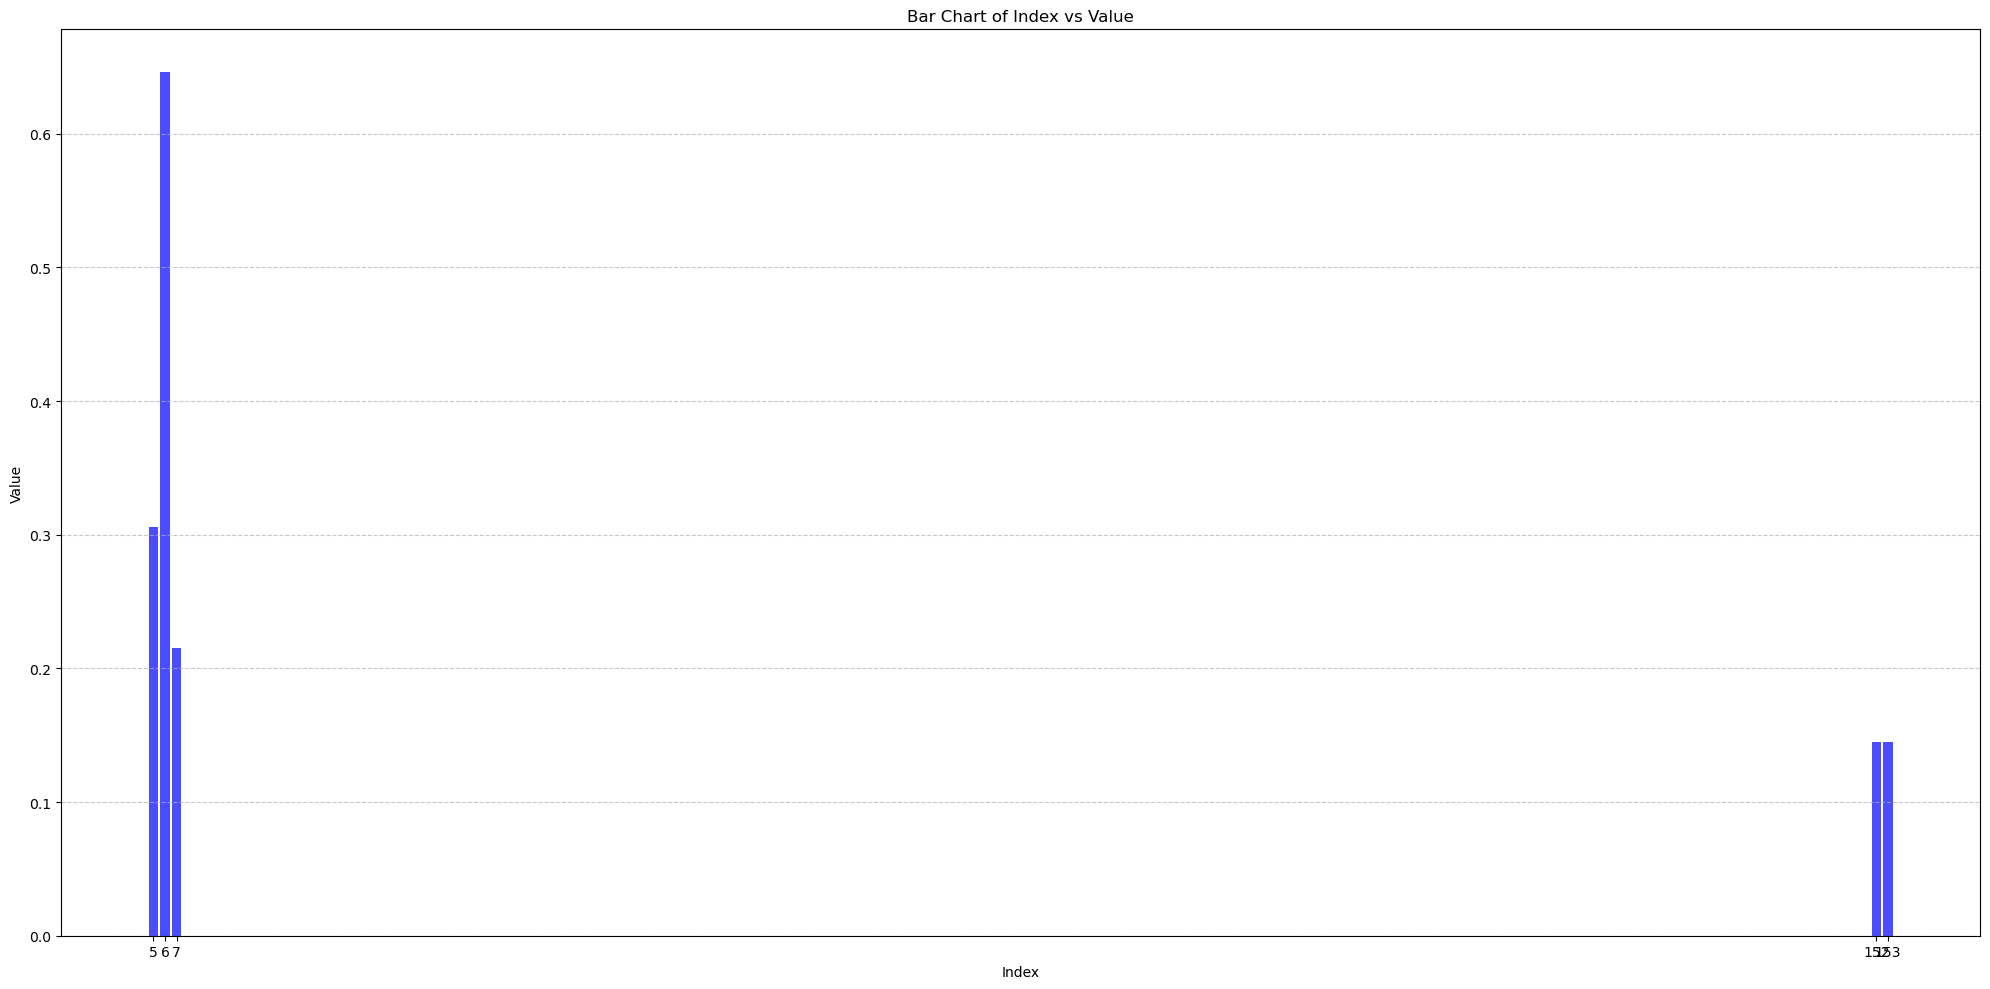

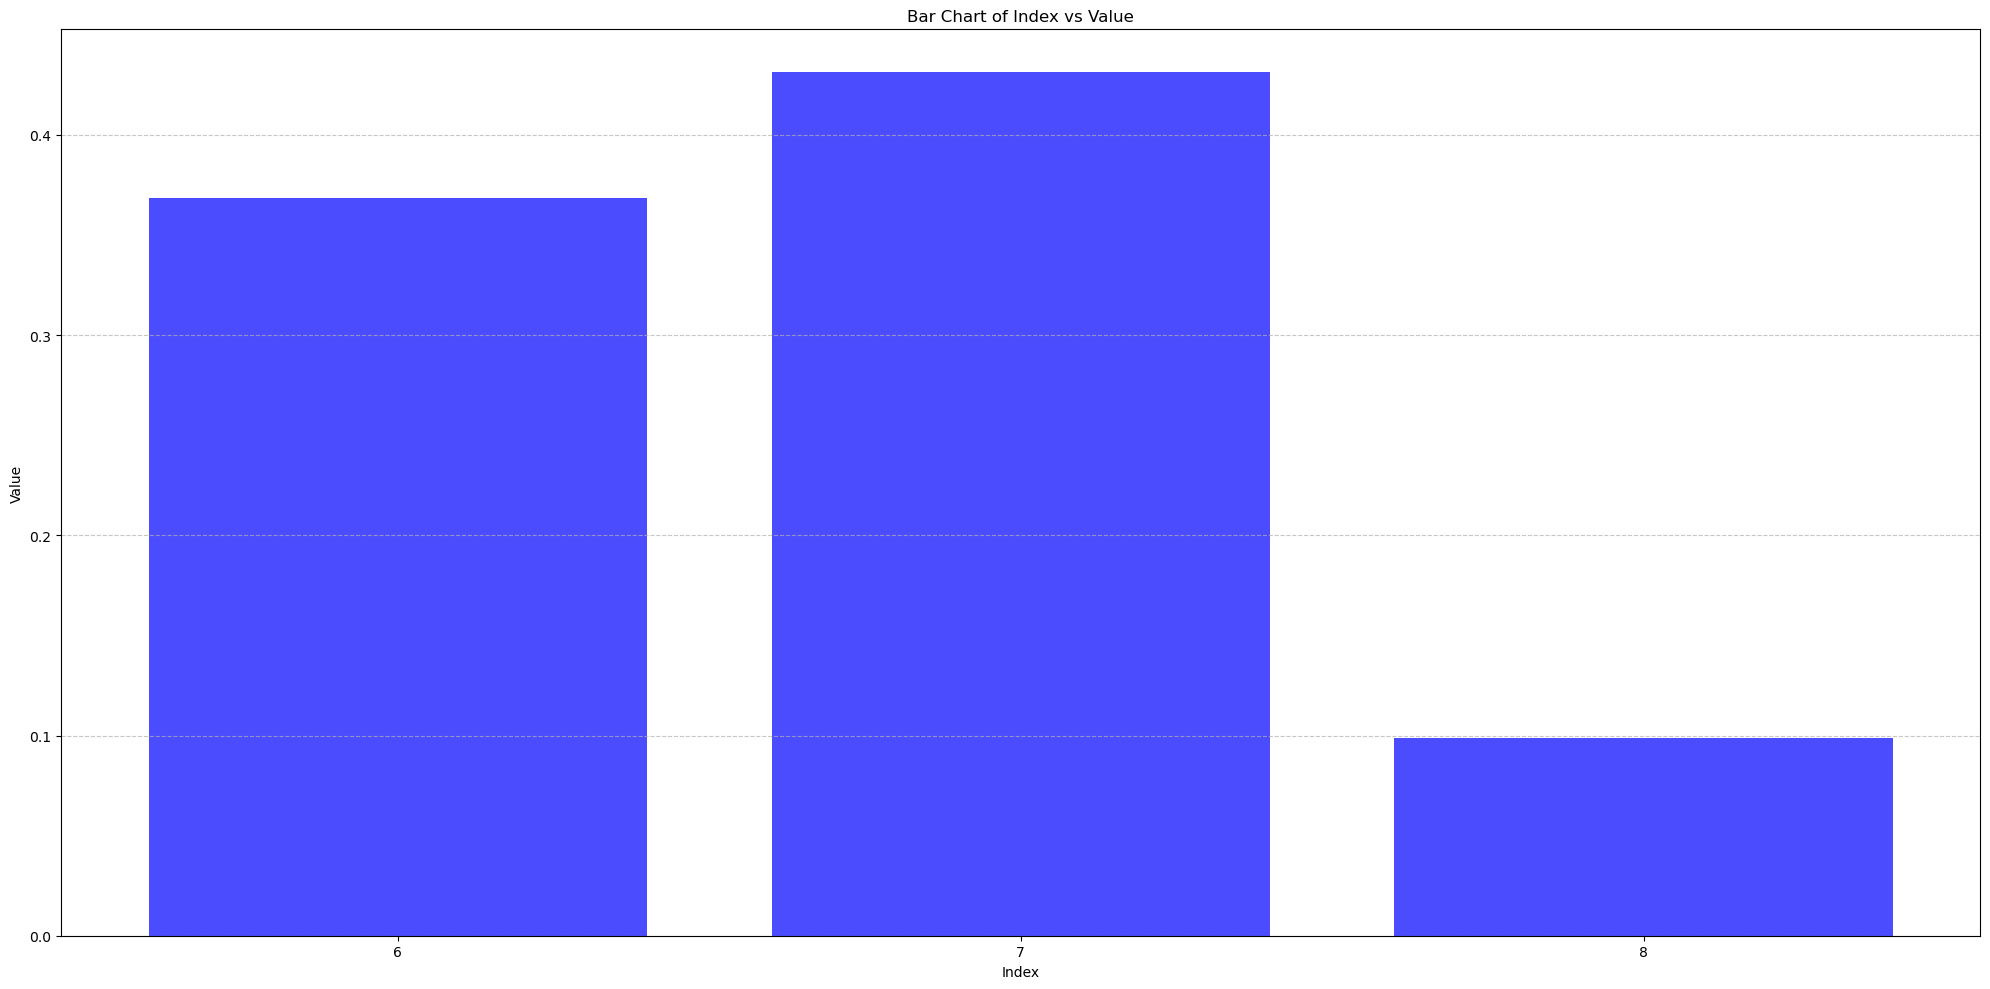

In [21]:
for q in [0, 1, 2]:
    indices, values = zip(*[(m[1], m[2]) for m in full_matches if m[0] == q])

    plt.figure(figsize=(20, 10))
    plt.bar(indices, values, color='blue', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Chart of Index vs Value')
    plt.xticks(indices)  # Setting x-ticks to show each index
    plt.tight_layout()  # Adjust layout for better appearance
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.show()

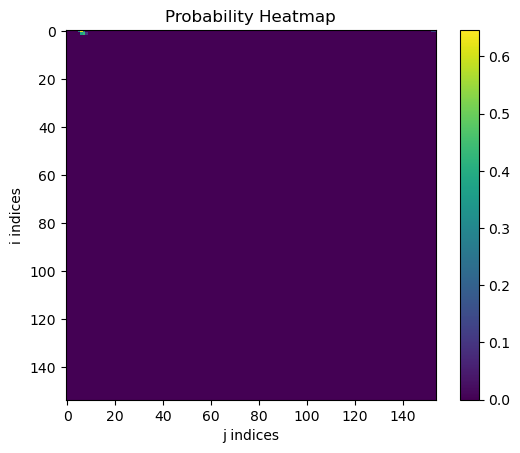

In [22]:
import torch

def construct_matrix(input_list):
    # Separate indices and probabilities
    i_indices, j_indices, probabilities = zip(*input_list)
    
    # Convert them to tensors
    i_indices = torch.tensor(i_indices, dtype=torch.long)
    j_indices = torch.tensor(j_indices, dtype=torch.long)
    probabilities = torch.tensor(probabilities)
    
    # Find the size of the matrix
    max_index = max(i_indices.max().item(), j_indices.max().item())
    
    # Create an empty matrix filled with zeros
    matrix = torch.zeros(max_index+1, max_index+1)
    
    # Use advanced indexing to fill the matrix
    matrix[i_indices, j_indices] = probabilities
    
    return matrix

chunks_matrix = construct_matrix(full_matches)

# Plotting the heatmap
plt.imshow(chunks_matrix, interpolation='nearest')
plt.colorbar()
plt.title("Probability Heatmap")
plt.xlabel("j indices")
plt.ylabel("i indices")
plt.show()

In [23]:
# let's pull out the first match
query, match, confidence = matches[0]
start_query = int(query * n_chars / 2)
end_query = start_query + n_chars
start_match = int(match * n_chars / 2)
end_match = start_match + n_chars

padding_chars = 20
query_window = prediction[start_query:end_query]
match_window = transcript[start_match:end_match]
expanded_match_window = transcript[max(0, start_match - padding_chars):(end_match + padding_chars)]

print("Query:")
print(query_window)
print()

print("Match:")
print(expanded_match_window)
print()

Query:
sible iconbut i have a question for you is it possible to even get near the bott

Match:
riumphant: the movies and meaning of an irrepressible icon.” but i have a question for you. is it possible to even get n



In [24]:
recording = dataset.Recording(
    f"keanu-{offset_seconds}:{length_seconds}", 
    snippet[0], 
    clean_text_fn(expanded_match_window), 
    expanded_match_window, 
    None, 
    cfg.sampling_rate
)

batch = dataset.collate_fn([recording])
xs, ys, ys_original, ids = batch
(xs, ys, ys_original, ids)
alignments = aligner.align((xs, ys, ys_original, ids))
alignment = alignments[0]

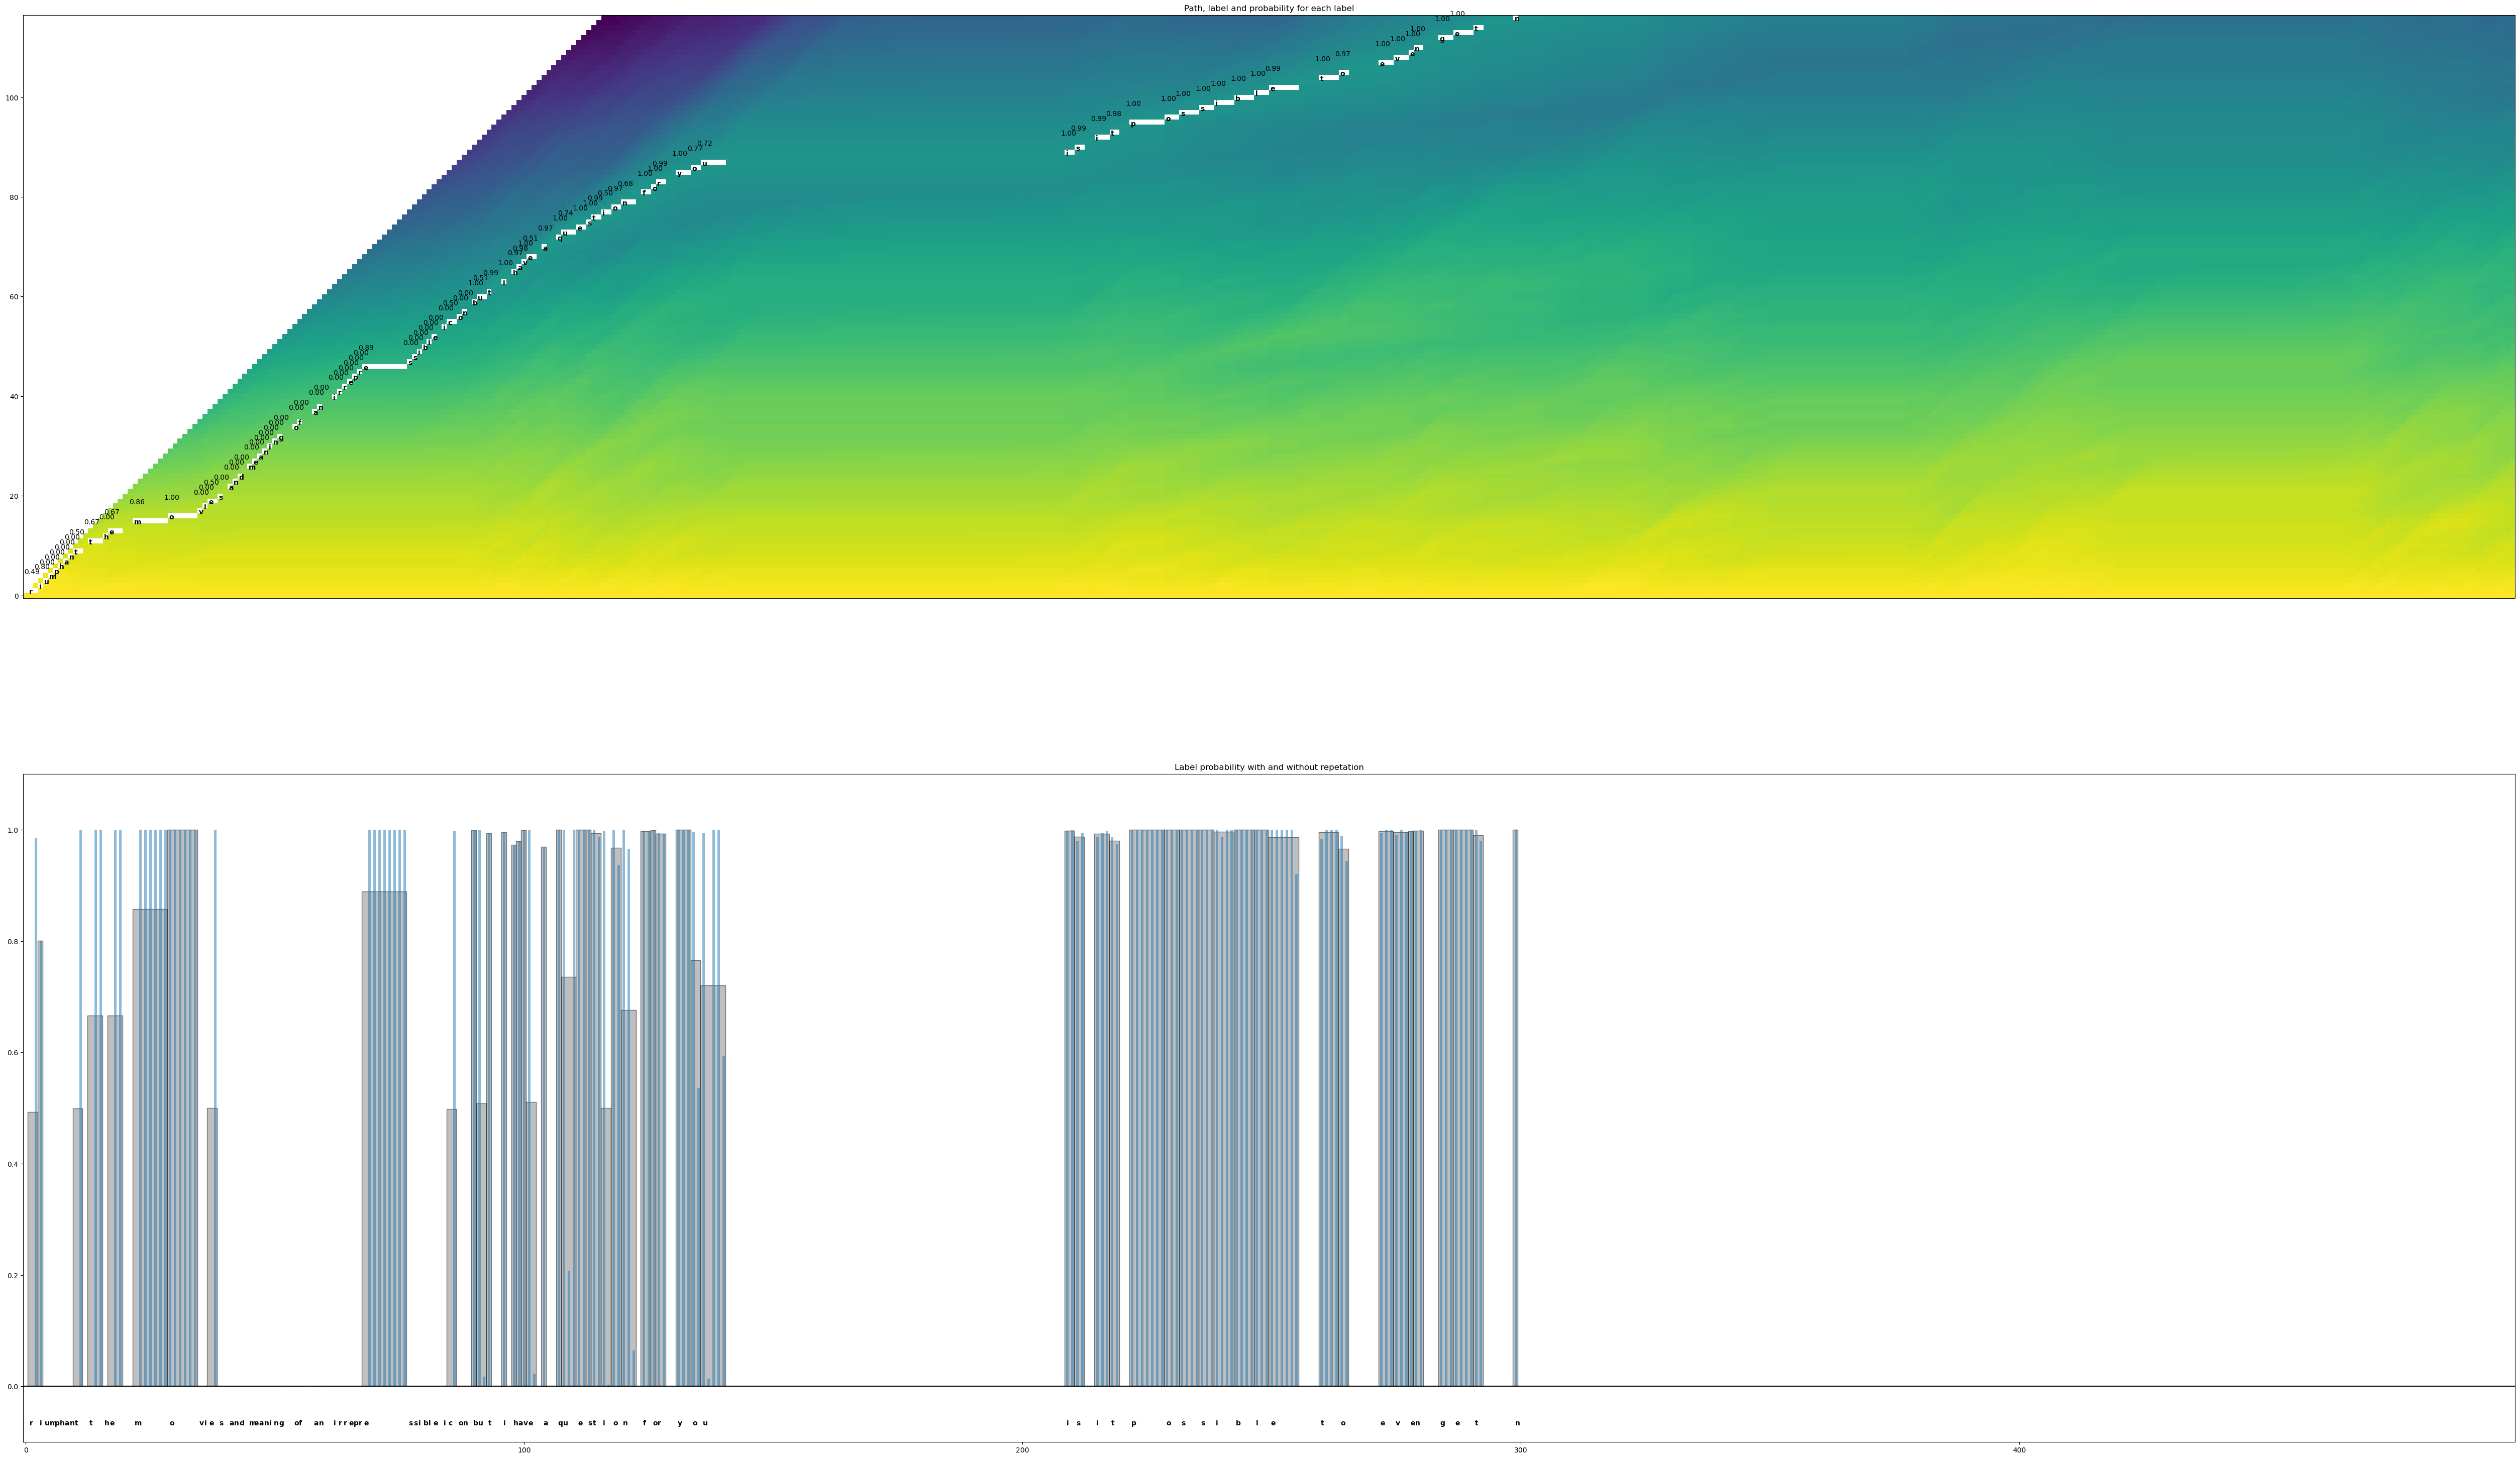

In [25]:
viz.plot_trellis_with_segments(alignment.trellis, alignment.chars_cleaned, ys[0], alignment.path);

In [26]:
alignment.words_cleaned

[Segment(label='riumphant', start=0, end=11, score=0.3154010466773987),
 Segment(label='the', start=12, end=19, score=0.5554794470129454),
 Segment(label='movies', start=21, end=39, score=0.6842398159754124),
 Segment(label='and', start=40, end=43, score=4.153489214786532e-06),
 Segment(label='meaning', start=44, end=51, score=0.11111359087237815),
 Segment(label='of', start=53, end=55, score=0.2500007939745963),
 Segment(label='an', start=57, end=59, score=0.2500039410178658),
 Segment(label='irrepressible', start=61, end=82, score=0.36364545100606593),
 Segment(label='icon', start=83, end=88, score=0.1666941948024198),
 Segment(label='but', start=89, end=93, score=0.6696588263536493),
 Segment(label='i', start=95, end=96, score=0.9678619205951691),
 Segment(label='have', start=97, end=102, score=0.8286972983429829),
 Segment(label='a', start=103, end=104, score=0.933459202448527),
 Segment(label='question', start=106, end=122, score=0.8328269310295582),
 Segment(label='for', start=12

Let's have a look at specific word in here:

In [27]:
word = "feeling"
chars_cleaned_scores = [s.score for s in alignment.chars_cleaned]
i_start_word = [s.label for s in alignment.words_cleaned].index(word)
test_word_segment = alignment.words_cleaned[i_start_word]
frame_start = test_word_segment.start
i_start_char = [s.start for s in alignment.chars_cleaned].index(frame_start)
test_char_segment = alignment.chars_cleaned[i_start_char]

print(f"word level segment for '{word}': ", i_start_word, test_word_segment)
print(f"character level segment for '{word}': ", i_start_char, test_char_segment)

ValueError: 'feeling' is not in list

In [ ]:
w = 10
smoothed = np.convolve(chars_cleaned_scores , np.ones(w), 'valid') / w

plt.figure(figsize=(20, 10))
plt.bar(range(len(chars_cleaned_scores )), chars_cleaned_scores )
plt.axvline(x=i_start_char, color='red')
plt.plot(smoothed, color="magenta")

The red line indicates where the test word starts. The blue lines are character level probabilities for the alignment. The magenta line is a smoothed version of that. 

Let's take a look at the selected word:

In [28]:
padding_ms = 20
padding_seconds = padding_ms / 1000

def show_word(word):
    start_seconds = max(0, alignment.model_frames_to_seconds(word.start) + padding_seconds)
    end_seconds = alignment.model_frames_to_seconds(word.end) + padding_seconds
    y, sr = utils.load_slice(fixtures_path / 'audio' / 'keanu.mp3', start_seconds, end_seconds)
    print(f"{word.label} ({word.start}:{word.end})")
    ipd.display(ipd.Audio(y, rate=sr))
        
show_word(test_word_segment)

NameError: name 'test_word_segment' is not defined

In [ ]:
for w in alignment.words_cleaned:
    if w.score > 0.75:
        print(w.label)
    else:
        print(f'? {w.label}')

# Issues

Some issues with the approach above. 

* First: doesn't seem to work at all lol
* We are indiscriminately chopping into pieces without paying attention to silences. Leading and trailing audio can and will be chopped into the middle of a word.
* Is there an issue with filling up the context windows on chunks?